# Sujet 1 : la concentration de CO₂ dans l’atmosphère (courbe de Keeling)
Version proposé par Guillaume Boileau

Ce document analyse l'évolution de la concentration de CO₂ dans l'atmosphère depuis 1958, à partir des données hebdomadaires de l'observatoire de Mauna Loa.

In [12]:
%matplotlib inline
import pandas as pd
import numpy as np
import os
import urllib.request
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from statsmodels.tsa.seasonal import seasonal_decompose

plt.rcParams['figure.figsize'] = (12, 5)


## 1. Chargement et visualisation des données

### a. URL des données et file_path local

In [13]:
url = "https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/monthly/monthly_in_situ_co2_mlo.csv"
file_path = "weekly_in_situ_co2_mlo.csv"

URL des données hebdomadaires (mise à jour en 2024) 

### b. Télécharger le fichier s’il n'existe pas localement

In [14]:
if not os.path.exists(file_path):
    urllib.request.urlretrieve(url, file_path)
    print("Fichier téléchargé depuis :", url)
else:
    print("Fichier local utilisé :", file_path)

Fichier local utilisé : weekly_in_situ_co2_mlo.csv


Ici l'on va télécharger les donnée si elle n'existe pas dans le dossier local sinon on utlise le fichier local. 

### c. Chargement brut et affichage des données

In [15]:
df_raw = pd.read_csv(file_path, skiprows=range(0, 61))
df_raw

Yr   Mn      Date         Date       CO2  seasonally          fit  \
0                                                  adjusted                
1                  Excel                  [ppm]      [ppm]         [ppm]   
2    1958   01     21200    1958.0411    -99.99      -99.99       -99.99   
3    1958   02     21231    1958.1260    -99.99      -99.99       -99.99   
4    1958   03     21259    1958.2027    315.71      314.43       316.20   
5    1958   04     21290    1958.2877    317.45      315.15       317.30   
6    1958   05     21320    1958.3699    317.51      314.68       317.89   
7    1958   06     21351    1958.4548    -99.99      -99.99       317.27   
8    1958   07     21381    1958.5370    315.87      315.20       315.85   
9    1958   08     21412    1958.6219    314.93      316.23       313.95   
10   1958   09     21443    1958.7068    313.21      316.13       312.42   
11   1958   10     21473    1958.7890    -99.99      -99.99       312.41   
12   1958   11     21504    1958.8740    313.33      315.21       313.60   
13   1958   12     21534    1958.9562    314.67      315.43       314.76   
14   1959   01     21565    1959.0411    315.58      315.52       315.64   
15   1959   02     21596    1959.1260    316.49      315.83       316.29   
16   1959   03     21624    1959.2027    316.65      315.37       316.99   
17   1959   04     21655    1959.2877    317.72      315.41       318.09   
18   1959   05     21685    1959.3699    318.29      315.46       318.68   
19   1959   06     21716    1959.4548    318.15      316.00       318.08   
20   1959   07     21746    1959.5370    316.54      315.87       316.67   
21   1959   08     21777    1959.6219    314.79      316.10       314.79   
22   1959   09     21808    1959.7068    313.84      316.76       313.28   
23   1959   10     21838    1959.7890    313.33      316.35       313.30   
24   1959   11     21869    1959.8740    314.81      316.70       314.53   
25   1959   12     21899    1959.9562    315.58      316.35       315.72   
26   1960   01     21930    1960.0410    316.43      316.37       316.62   
27   1960   02     21961    1960.1257    316.98      316.33       317.30   
28   1960   03     21990    1960.2049    317.58      316.27       318.04   
29   1960   04     22021    1960.2896    319.03      316.69       319.14   
..    ...  ...       ...          ...       ...         ...          ...   
788  2023   07     45122    2023.5370    421.62      420.82       421.71   
789  2023   08     45153    2023.6219    419.56      421.11       419.66   
790  2023   09     45184    2023.7068    418.06      421.56       418.06   
791  2023   10     45214    2023.7890    418.41      422.01       418.29   
792  2023   11     45245    2023.8740    420.11      422.37       419.96   
793  2023   12     45275    2023.9562    421.65      422.57       421.59   
794  2024   01     45306    2024.0410    422.62      422.55       422.87   
795  2024   02     45337    2024.1257    424.34      423.56       423.87   
796  2024   03     45366    2024.2049    425.22      423.66       424.93   
797  2024   04     45397    2024.2896    426.30      423.51       426.45   
798  2024   05     45427    2024.3716    426.70      423.31       427.30   
799  2024   06     45458    2024.4563    426.62      424.07       426.72   
800  2024   07     45488    2024.5383    425.40      424.63       425.20   
801  2024   08     45519    2024.6230    422.70      424.29       423.11   
802  2024   09     45550    2024.7077    421.60      425.11       421.49   
803  2024   10     45580    2024.7896    422.05      425.65       421.69   
804  2024   11     45611    2024.8743    423.61      425.86       423.31   
805  2024   12     45641    2024.9563    425.01      425.93       424.87   
806  2025   01     45672    2025.0411    426.42      426.35       426.09   
807  2025   02     45703    2025.1260    427.00      426.21       427.03   
808  2025   03     45731    2025.2027    427.73      42

Les 62 premières lignes sont des explications : nous pouvons ne pas les charger pour le reste de l’analyse des données.

Nous remarquons des lignes contenant la valeur `-99.99` : cela indique que la mesure n’a pas été effectuée avec succès.  
Il faudra filtrer ces valeurs lors de l’analyse.

In [16]:
print('Columns : ', df_raw.columns)
print('head : ', df_raw.head())

Columns :  Index(['  Yr', ' Mn', '    Date', '      Date', '     CO2', 'seasonally',
       '        fit', '  seasonally', '      CO2', ' seasonally', ' Sta'],
      dtype='object')
head :       Yr   Mn      Date         Date       CO2  seasonally          fit  \
0                                                adjusted                
1                Excel                  [ppm]      [ppm]         [ppm]   
2  1958   01     21200    1958.0411    -99.99      -99.99       -99.99   
3  1958   02     21231    1958.1260    -99.99      -99.99       -99.99   
4  1958   03     21259    1958.2027    315.71      314.43       316.20   

     seasonally           CO2       seasonally   Sta  
0  adjusted fit        filled  adjusted filled   NaN  
1         [ppm]         [ppm]            [ppm]   NaN  
2        -99.99        -99.99           -99.99   MLO  
3        -99.99        -99.99           -99.99   MLO  
4        314.90        315.71           314.43   MLO  


## 2. Traitement de la courbe

In [65]:
df = df_raw.copy()

In [66]:
raw_columns = list(df_raw.columns)
cleaned = [col.strip().replace(" ", "_") for col in df.columns]
seen = {}
final_columns = []
for col in cleaned:
    if col not in seen:
        seen[col] = 1
        final_columns.append(col)
    else:
        seen[col] += 1
        final_columns.append(f"{col}_{seen[col]}")
df.columns = final_columns

print(df.columns)
print(df.shape)        
print(df.head())       


Index(['Yr', 'Mn', 'Date', 'Date_2', 'CO2', 'seasonally', 'fit',
       'seasonally_2', 'CO2_2', 'seasonally_3', 'Sta'],
      dtype='object')
(818, 11)
     Yr   Mn      Date       Date_2       CO2  seasonally          fit  \
0                                                adjusted                
1                Excel                  [ppm]      [ppm]         [ppm]   
2  1958   01     21200    1958.0411    -99.99      -99.99       -99.99   
3  1958   02     21231    1958.1260    -99.99      -99.99       -99.99   
4  1958   03     21259    1958.2027    315.71      314.43       316.20   

   seasonally_2         CO2_2     seasonally_3   Sta  
0  adjusted fit        filled  adjusted filled   NaN  
1         [ppm]         [ppm]            [ppm]   NaN  
2        -99.99        -99.99           -99.99   MLO  
3        -99.99        -99.99           -99.99   MLO  
4        314.90        315.71           314.43   MLO  


In [67]:
df

Yr   Mn      Date       Date_2       CO2  seasonally          fit  \
0                                                  adjusted                
1                  Excel                  [ppm]      [ppm]         [ppm]   
2    1958   01     21200    1958.0411    -99.99      -99.99       -99.99   
3    1958   02     21231    1958.1260    -99.99      -99.99       -99.99   
4    1958   03     21259    1958.2027    315.71      314.43       316.20   
5    1958   04     21290    1958.2877    317.45      315.15       317.30   
6    1958   05     21320    1958.3699    317.51      314.68       317.89   
7    1958   06     21351    1958.4548    -99.99      -99.99       317.27   
8    1958   07     21381    1958.5370    315.87      315.20       315.85   
9    1958   08     21412    1958.6219    314.93      316.23       313.95   
10   1958   09     21443    1958.7068    313.21      316.13       312.42   
11   1958   10     21473    1958.7890    -99.99      -99.99       312.41   
12   1958   11     21504    1958.8740    313.33      315.21       313.60   
13   1958   12     21534    1958.9562    314.67      315.43       314.76   
14   1959   01     21565    1959.0411    315.58      315.52       315.64   
15   1959   02     21596    1959.1260    316.49      315.83       316.29   
16   1959   03     21624    1959.2027    316.65      315.37       316.99   
17   1959   04     21655    1959.2877    317.72      315.41       318.09   
18   1959   05     21685    1959.3699    318.29      315.46       318.68   
19   1959   06     21716    1959.4548    318.15      316.00       318.08   
20   1959   07     21746    1959.5370    316.54      315.87       316.67   
21   1959   08     21777    1959.6219    314.79      316.10       314.79   
22   1959   09     21808    1959.7068    313.84      316.76       313.28   
23   1959   10     21838    1959.7890    313.33      316.35       313.30   
24   1959   11     21869    1959.8740    314.81      316.70       314.53   
25   1959   12     21899    1959.9562    315.58      316.35       315.72   
26   1960   01     21930    1960.0410    316.43      316.37       316.62   
27   1960   02     21961    1960.1257    316.98      316.33       317.30   
28   1960   03     21990    1960.2049    317.58      316.27       318.04   
29   1960   04     22021    1960.2896    319.03      316.69       319.14   
..    ...  ...       ...          ...       ...         ...          ...   
788  2023   07     45122    2023.5370    421.62      420.82       421.71   
789  2023   08     45153    2023.6219    419.56      421.11       419.66   
790  2023   09     45184    2023.7068    418.06      421.56       418.06   
791  2023   10     45214    2023.7890    418.41      422.01       418.29   
792  2023   11     45245    2023.8740    420.11      422.37       419.96   
793  2023   12     45275    2023.9562    421.65      422.57       421.59   
794  2024   01     45306    2024.0410    422.62      422.55       422.87   
795  2024   02     45337    2024.1257    424.34      423.56       423.87   
796  2024   03     45366    2024.2049    425.22      423.66       424.93   
797  2024   04     45397    2024.2896    426.30      423.51       426.45   
798  2024   05     45427    2024.3716    426.70      423.31       427.30   
799  2024   06     45458    2024.4563    426.62      424.07       426.72   
800  2024   07     45488    2024.5383    425.40      424.63       425.20   
801  2024   08     45519    2024.6230    422.70      424.29       423.11   
802  2024   09     45550    2024.7077    421.60      425.11       421.49   
803  2024   10     45580    2024.7896    422.05      425.65       421.69   
804  2024   11     45611    2024.8743    423.61      425.86       423.31   
805  2024   12     45641    2024.9563    425.01      425.93       424.87   
806  2025   01     45672    2025.0411    426.42      426.35       426.09   
807  2025   02     45703    2025.1260    427.00      426.21       427.03   
808  2025   03     45731    2025.2027    427.73      42

Nettoyage des noms de colonnes : on supprime les espaces avec `strip().replace(" ", "_")` et on rend les noms uniques en ajoutant un suffixe `_2`, `_3`, etc. en cas de doublons.

In [68]:
df['Yr'] = pd.to_numeric(df['Yr'], errors='coerce')
df['Mn'] = pd.to_numeric(df['Mn'], errors='coerce')
df = df.dropna(subset=['Yr', 'Mn'])
df['date'] = pd.to_datetime(df[['Yr', 'Mn']].rename(columns={'Yr': 'year', 'Mn': 'month'}).assign(day=1))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


On convertit les colonnes 'Yr' et 'Mn' en nombres avec `pd.to_numeric(..., errors='coerce')` pour éviter les erreurs de conversion de date causées par des valeurs vides ou invalides.


In [69]:
df

Yr    Mn      Date       Date_2       CO2 seasonally          fit  \
2    1958.0   1.0     21200    1958.0411    -99.99     -99.99       -99.99   
3    1958.0   2.0     21231    1958.1260    -99.99     -99.99       -99.99   
4    1958.0   3.0     21259    1958.2027    315.71     314.43       316.20   
5    1958.0   4.0     21290    1958.2877    317.45     315.15       317.30   
6    1958.0   5.0     21320    1958.3699    317.51     314.68       317.89   
7    1958.0   6.0     21351    1958.4548    -99.99     -99.99       317.27   
8    1958.0   7.0     21381    1958.5370    315.87     315.20       315.85   
9    1958.0   8.0     21412    1958.6219    314.93     316.23       313.95   
10   1958.0   9.0     21443    1958.7068    313.21     316.13       312.42   
11   1958.0  10.0     21473    1958.7890    -99.99     -99.99       312.41   
12   1958.0  11.0     21504    1958.8740    313.33     315.21       313.60   
13   1958.0  12.0     21534    1958.9562    314.67     315.43       314.76   
14   1959.0   1.0     21565    1959.0411    315.58     315.52       315.64   
15   1959.0   2.0     21596    1959.1260    316.49     315.83       316.29   
16   1959.0   3.0     21624    1959.2027    316.65     315.37       316.99   
17   1959.0   4.0     21655    1959.2877    317.72     315.41       318.09   
18   1959.0   5.0     21685    1959.3699    318.29     315.46       318.68   
19   1959.0   6.0     21716    1959.4548    318.15     316.00       318.08   
20   1959.0   7.0     21746    1959.5370    316.54     315.87       316.67   
21   1959.0   8.0     21777    1959.6219    314.79     316.10       314.79   
22   1959.0   9.0     21808    1959.7068    313.84     316.76       313.28   
23   1959.0  10.0     21838    1959.7890    313.33     316.35       313.30   
24   1959.0  11.0     21869    1959.8740    314.81     316.70       314.53   
25   1959.0  12.0     21899    1959.9562    315.58     316.35       315.72   
26   1960.0   1.0     21930    1960.0410    316.43     316.37       316.62   
27   1960.0   2.0     21961    1960.1257    316.98     316.33       317.30   
28   1960.0   3.0     21990    1960.2049    317.58     316.27       318.04   
29   1960.0   4.0     22021    1960.2896    319.03     316.69       319.14   
30   1960.0   5.0     22051    1960.3716    320.03     317.19       319.70   
31   1960.0   6.0     22082    1960.4563    319.59     317.44       319.04   
..      ...   ...       ...          ...       ...        ...          ...   
788  2023.0   7.0     45122    2023.5370    421.62     420.82       421.71   
789  2023.0   8.0     45153    2023.6219    419.56     421.11       419.66   
790  2023.0   9.0     45184    2023.7068    418.06     421.56       418.06   
791  2023.0  10.0     45214    2023.7890    418.41     422.01       418.29   
792  2023.0  11.0     45245    2023.8740    420.11     422.37       419.96   
793  2023.0  12.0     45275    2023.9562    421.65     422.57       421.59   
794  2024.0   1.0     45306    2024.0410    422.62     422.55       422.87   
795  2024.0   2.0     45337    2024.1257    424.34     423.56       423.87   
796  2024.0   3.0     45366    2024.2049    425.22     423.66       424.93   
797  2024.0   4.0     45397    2024.2896    426.30     423.51       426.45   
798  2024.0   5.0     45427    2024.3716    426.70     423.31       427.30   
799  2024.0   6.0     45458    2024.4563    426.62     424.07       426.72   
800  2024.0   7.0     45488    2024.5383    425.40     424.63       425.20   
801  2024.0   8.0     45519    2024.6230    422.70     424.29       423.11   
802  2024.0   9.0     45550    2024.7077    421.60     425.11       421.49   
803  2024.0  10.0     45580    2024.7896    422.05     425.65       421.69   
804  2024.0  11.0     45611    2024.8743    423.61     425.86       423.31   
805  2024.0  12.0     45641    2024.9563    425.01     425.93       424.87   
806  2025.0   1.0     45672    2025.0411    426.42     426.35       426.09   
807  2025.0   2.0     45703    

In [70]:
df['CO2'] = pd.to_numeric(df['CO2'], errors='coerce')
df = df[df['CO2'] != -99.99]
df = df[['date', 'CO2']].set_index('date')


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


On filtre les lignes avec une vraie valeur de CO₂ (`≠ -99.99`) et on définit la colonne `date` comme index du DataFrame.

In [71]:
df

CO2
date              
1958-03-01  315.71
1958-04-01  317.45
1958-05-01  317.51
1958-07-01  315.87
1958-08-01  314.93
1958-09-01  313.21
1958-11-01  313.33
1958-12-01  314.67
1959-01-01  315.58
1959-02-01  316.49
1959-03-01  316.65
1959-04-01  317.72
1959-05-01  318.29
1959-06-01  318.15
1959-07-01  316.54
1959-08-01  314.79
1959-09-01  313.84
1959-10-01  313.33
1959-11-01  314.81
1959-12-01  315.58
1960-01-01  316.43
1960-02-01  316.98
1960-03-01  317.58
1960-04-01  319.03
1960-05-01  320.03
1960-06-01  319.59
1960-07-01  318.18
1960-08-01  315.90
1960-09-01  314.17
1960-10-01  313.83
...            ...
2022-12-01  418.46
2023-01-01  419.13
2023-02-01  420.33
2023-03-01  420.51
2023-04-01  422.73
2023-05-01  423.78
2023-06-01  423.39
2023-07-01  421.62
2023-08-01  419.56
2023-09-01  418.06
2023-10-01  418.41
2023-11-01  420.11
2023-12-01  421.65
2024-01-01  422.62
2024-02-01  424.34
2024-03-01  425.22
2024-04-01  426.30
2024-05-01  426.70
2024-06-01  426.62
2024-07-01  425.40
2024-08-01  422.70
2024-09-01  421.60
2024-10-01  422.05
2024-11-01  423.61
2024-12-01  425.01
2025-01-01  426.42
2025-02-01  427.00
2025-03-01  427.73
2025-04-01  429.24
2025-05-01  430.20

[802 rows x 1 columns]

## 2. Oscillation périodique et tendance de fond du CO₂

Le graphique ci-dessous représente la concentration mensuelle de CO₂ mesurée à l’observatoire de Mauna Loa à Hawaii depuis 1958.  
On observe deux composantes principales :
- Une **tendance croissante lente** à long terme, liée à l’augmentation des émissions anthropiques.
- Une **oscillation périodique annuelle**, due à la photosynthèse et la respiration des plantes dans l'hémisphère nord.

Ce double comportement est typique des séries climatiques, où des variations saisonnières se superposent à une évolution systémique.



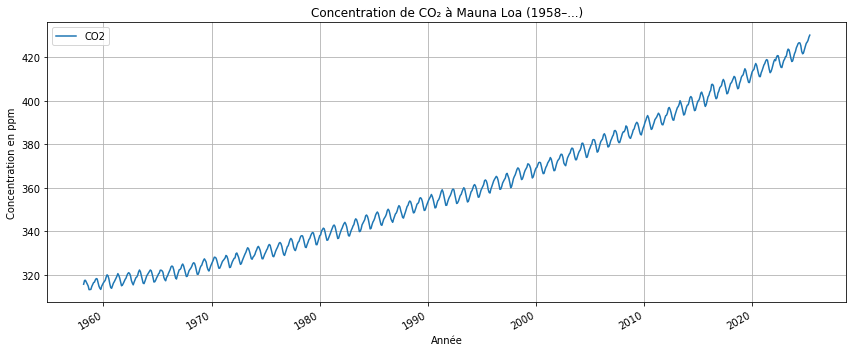

In [75]:
df.plot(figsize=(12, 5), title="Concentration de CO₂ à Mauna Loa (1958–...)")
plt.ylabel("Concentration en ppm")
plt.xlabel("Année")
plt.grid(True)
plt.tight_layout()
plt.show()

## 3. Décomposition de la série temporelle : tendance, saisonnalité et résidu

On interpole les valeurs manquantes de la série CO₂ pour permettre une décomposition saisonnière avec `seasonal_decompose()`.

On décompose la série de concentration mensuelle de CO₂ en trois composantes : la tendance à long terme, les variations saisonnières régulières et les résidus aléatoires.


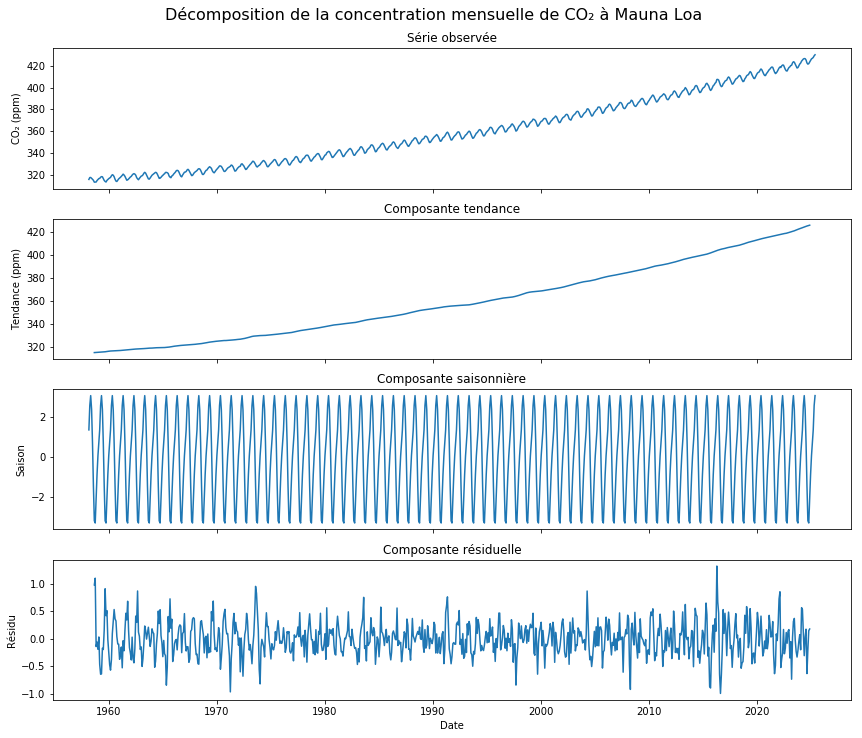

In [85]:
result = seasonal_decompose(df['CO2'], model='additive')
trend = result.trend
seasonal = result.seasonal
resid = result.resid
observed = result.observed

fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

axs[0].plot(observed, label="Observé")
axs[0].set_ylabel("CO₂ (ppm)")
axs[0].set_title("Série observée")

axs[1].plot(trend, label="Tendance")
axs[1].set_ylabel("Tendance (ppm)")
axs[1].set_title("Composante tendance")

axs[2].plot(seasonal, label="Saisonnalité")
axs[2].set_ylabel("Saison")
axs[2].set_title("Composante saisonnière")

axs[3].plot(resid, label="Résidus")
axs[3].set_ylabel("Résidu")
axs[3].set_title("Composante résiduelle")
axs[3].set_xlabel("Date")

fig.suptitle("Décomposition de la concentration mensuelle de CO₂ à Mauna Loa", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


## 4. Modélisation de la série temporelle
On ajuste un modèle polynomial à la tendance estimée et on l'extrapole jusqu'en 2025 pour valider le modèle avec des données futures.


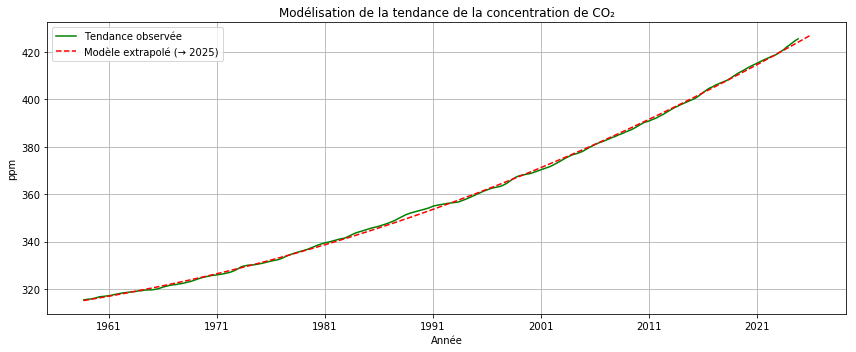

In [88]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
import matplotlib.pyplot as plt

trend = result.trend.dropna()
X = trend.index.map(pd.Timestamp.toordinal).values.reshape(-1, 1)
y = trend.values

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)
model = LinearRegression().fit(X_poly, y)

future_dates = pd.date_range(trend.index.min(), '2025-12-01', freq='MS')
X_future = future_dates.map(pd.Timestamp.toordinal).values.reshape(-1, 1)
X_future_poly = poly.transform(X_future)
y_future = model.predict(X_future_poly)

plt.figure(figsize=(12, 5))
plt.plot(trend.index, trend.values, label="Tendance observée", color='green')
plt.plot(future_dates, y_future, label="Modèle extrapolé (→ 2025)", color='red', linestyle='--')
plt.title("Modélisation de la tendance de la concentration de CO₂")
plt.xlabel("Année")
plt.ylabel("ppm")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 4. Validation du modèle de tendance (polynôme degré 2)

Nous avons modélisé la tendance lente de la concentration de CO₂ à Mauna Loa à l'aide d'un polynôme de degré 2. Voici les résultats de l’analyse des résidus :

- **Erreur quadratique moyenne RMSE** : ≈ 0.663 ppm  
  - Le modèle est précis à `~0.66 ppm` en moyenne par rapport aux données observées.

- **Coeff de cohérence R²** : 0.9996  
  - Le modèle explique **plus de `99.96 %` de la variance** totale. La tendance est donc extrêmement bien capturée.

- **Test de Shapiro-Wilk (Normalité)** :  
  Le test donne une p-value < 0.05, ce qui **rejette l’hypothèse de normalité** des résidus à un seuil de 5 %.  
  Cela indique que certains effets ne sont pas capturés par le modèle polynomial seul (ex. : périodicité, non-linéarité plus complexe). Nous alons l'analyser après.

#### Analyse visuelle des résidus :
- Les **résidus** ne sont pas aléatoirement répartis autour de zéro : on observe une légère forme en cloche et une dérive.
- Les erreur relative entre le model et les données ne devie pas à plus de **0.5%**
- L’**histogramme des résidus** confirme un **comportement asymétrique**

**Conclusion** : le modèle de tendance reproduit très bien la dynamique lente du CO₂ (croissance), mais il reste des **composantes saisonnières ou structurelles** non prises en compte. 


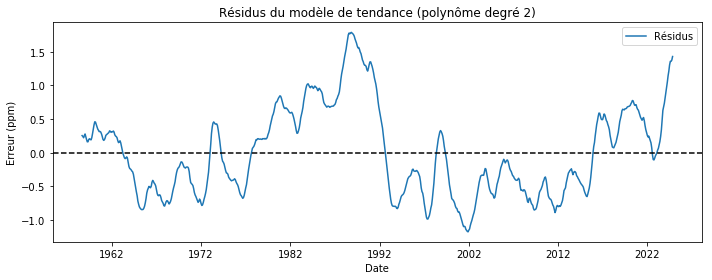

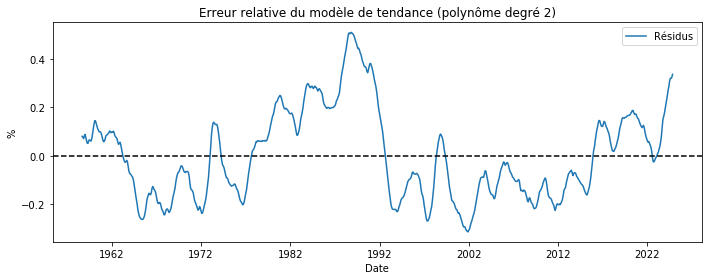

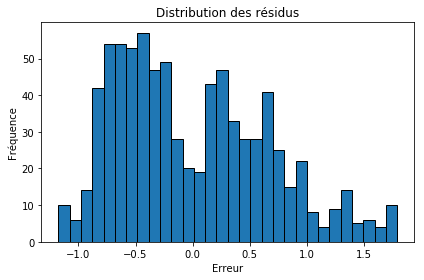

RMSE (erreur quadratique moyenne) : 0.663 ppm
R² (coefficient de détermination) : 0.9996
Test de Shapiro-Wilk pour normalité des résidus :
  W = 0.9550, p-value = 0.0000


In [92]:
from sklearn.metrics import mean_squared_error, r2_score
import scipy.stats as stats

y_pred = model.predict(X_poly)
residuals = y - y_pred.flatten()
Error_relative = residuals/y_pred*100

plt.figure(figsize=(10, 4))
plt.plot(trend.index, residuals, label="Résidus")
plt.axhline(0, color='black', linestyle='--')
plt.title("Résidus du modèle de tendance (polynôme degré 2)")
plt.xlabel("Date")
plt.ylabel("Erreur (ppm)")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(trend.index, Error_relative, label="Résidus")
plt.axhline(0, color='black', linestyle='--')
plt.title("Erreur relative du modèle de tendance (polynôme degré 2)")
plt.xlabel("Date")
plt.ylabel("%")
plt.legend()
plt.tight_layout()
plt.show()


plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=30, edgecolor='black')
plt.title("Distribution des résidus")
plt.xlabel("Erreur")
plt.ylabel("Fréquence")
plt.tight_layout()
plt.show()

mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
shapiro_test = stats.shapiro(residuals)

print(f"RMSE (erreur quadratique moyenne) : {mse**0.5:.3f} ppm")
print(f"R² (coefficient de détermination) : {r2:.4f}")
print("Test de Shapiro-Wilk pour normalité des résidus :")
print(f"  W = {shapiro_test[0]:.4f}, p-value = {shapiro_test[1]:.4f}")



## 5. Analyse fréquentielle de la composante saisonnière

Nous avons appliqué une transformée de Fourier discrète (FFT) à la composante saisonnière extraite des données de CO₂. Le spectre de puissance montre un pic net correspondant à une **fréquence dominante** de :

- **Période dominante ≈ 12 mois**

Ce résultat confirme la présence d'une **oscillation annuelle**, typique du cycle saisonnier de la concentration atmosphérique de CO₂ liée à l’activité photosynthétique et aux échanges saisonniers de carbone entre la biosphère et l’atmosphère.


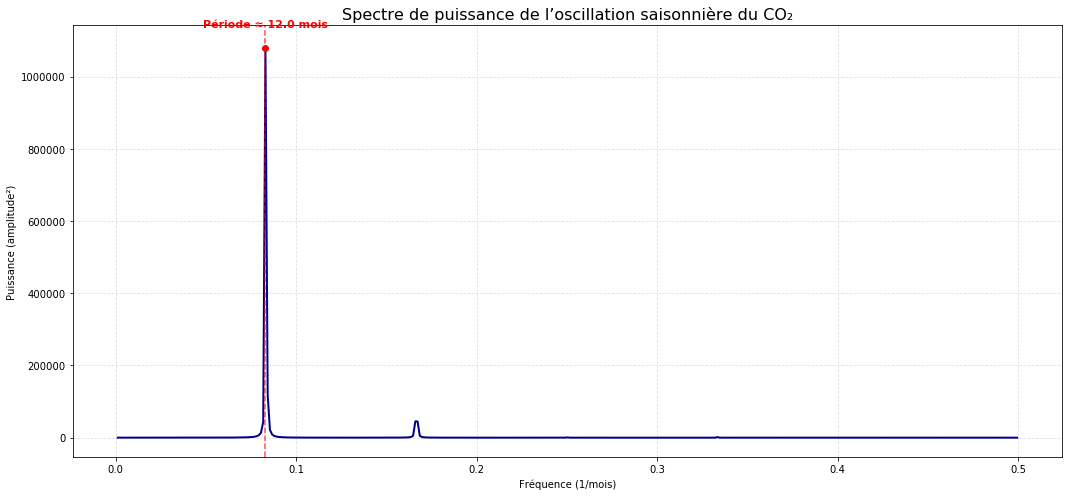

In [100]:
import numpy as np
import matplotlib.pyplot as plt


seasonal = result.seasonal.dropna()

fft_vals = np.fft.fft(seasonal.values)
fft_freqs = np.fft.fftfreq(len(seasonal), d=1)
mask = fft_freqs > 0
freqs = fft_freqs[mask]
power = np.abs(fft_vals[mask])**2

dominant_idx = np.argmax(power)
dominant_freq = freqs[dominant_idx]
dominant_period = 1 / dominant_freq

plt.figure(figsize=(15, 7))
plt.plot(freqs, power, color='darkblue', linewidth=2)
plt.scatter(dominant_freq, power[dominant_idx], color='red', zorder=5)
plt.axvline(dominant_freq, color='red', linestyle='--', alpha=0.7)

plt.text(dominant_freq, power[dominant_idx] * 1.05,
         f"Période ≈ {dominant_period:.1f} mois", color='red',
         ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.title("Spectre de puissance de l’oscillation saisonnière du CO₂", fontsize=16)
plt.xlabel("Fréquence (1/mois)")
plt.ylabel("Puissance (amplitude²)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()




###  6. Évolution de l’amplitude annuelle du cycle saisonnier

Le graphique montre l’évolution de l’**amplitude du cycle saisonnier** du CO₂ (différence entre le maximum et le minimum mensuels) pour chaque année depuis le début des mesures à Mauna Loa.

- On observe que l’amplitude du cycle saisonnier du CO₂ **rester globalement stable**, autour de **6.4 ppm**.
- Cela suggère que les échanges saisonniers entre l’atmosphère et la biosphère **restent relativement constants** en intensité au fil des décennies.

1959    6.401114
1960    6.401114
1961    6.401114
1962    6.401114
1963    6.401114
1964    6.401114
1965    6.401114
1966    6.401114
1967    6.401114
1968    6.401114
1969    6.401114
1970    6.401114
1971    6.401114
1972    6.401114
1973    6.401114
1974    6.401114
1975    6.401114
1976    6.401114
1977    6.401114
1978    6.401114
1979    6.401114
1980    6.401114
1981    6.401114
1982    6.401114
1983    6.401114
1984    6.401114
1985    6.401114
1986    6.401114
1987    6.401114
1988    6.401114
          ...   
1995    6.401114
1996    6.401114
1997    6.401114
1998    6.401114
1999    6.401114
2000    6.401114
2001    6.401114
2002    6.401114
2003    6.401114
2004    6.401114
2005    6.401114
2006    6.401114
2007    6.401114
2008    6.401114
2009    6.401114
2010    6.401114
2011    6.401114
2012    6.401114
2013    6.401114
2014    6.401114
2015    6.401114
2016    6.401114
2017    6.401114
2018    6.401114
2019    6.401114
2020    6.401114
2021    6.401114
2022    6.4011

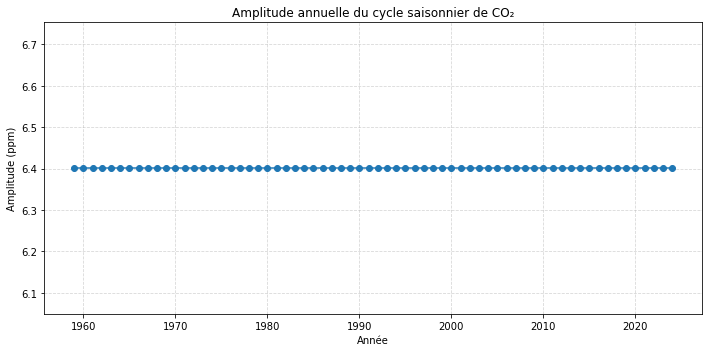

In [115]:
grouped = seasonal.groupby(seasonal.index.year)
complete_years = grouped.filter(lambda x: len(x) == 12).groupby(lambda x: x.year)
amplitude_by_year = complete_years.apply(lambda x: x.max() - x.min())
print(amplitude_by_year)
plt.figure(figsize=(10, 5))
amplitude_by_year.plot(marker='o')
plt.title("Amplitude annuelle du cycle saisonnier de CO₂")
plt.xlabel("Année")
plt.ylabel("Amplitude (ppm)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


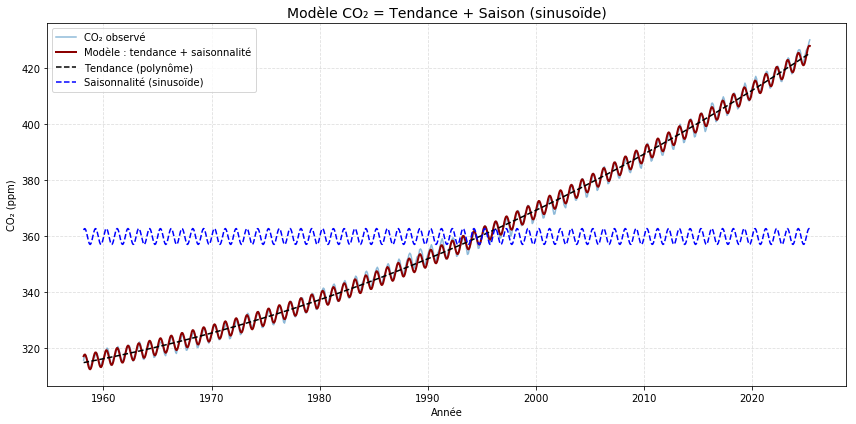

Paramètres du modèle :
  a0 = 51087.794
  a1 = -52.590
  a2 = 0.01362
  A = 2.852 ppm
  phi = -0.109 rad


In [114]:
df_interp = df['CO2'].interpolate() 
t = df_interp.index.year + (df_interp.index.month - 1) / 12 
y = df_interp.values

def model(t, a0, a1, a2, A, phi):
    trend = a0 + a1 * t + a2 * t**2
    seasonal = A * np.sin(2 * np.pi * t + phi)
    return trend + seasonal

popt, _ = curve_fit(model, t, y, p0=[300, 1, 0, 2, 0])

t_fit = np.linspace(t.min(), t.max(), 1000)
y_fit = model(t_fit, *popt)

plt.figure(figsize=(12, 6))
plt.plot(t, y, label="CO₂ observé", alpha=0.5)
plt.plot(t_fit, y_fit, label="Modèle : tendance + saisonnalité", color="darkred", linewidth=2)

trend_only = popt[0] + popt[1] * t_fit + popt[2] * t_fit**2
plt.plot(t_fit, trend_only, '--', label="Tendance (polynôme)", color="black")

seasonal_only = popt[3] * np.sin(2 * np.pi * t_fit + popt[4])
plt.plot(t_fit, seasonal_only + np.mean(y), '--', label="Saisonnalité (sinusoïde)", color="blue")

plt.title("Modèle CO₂ = Tendance + Saison (sinusoïde)", fontsize=14)
plt.xlabel("Année")
plt.ylabel("CO₂ (ppm)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

a0, a1, a2, A, phi = popt
print(f"Paramètres du modèle :\n  a0 = {a0:.3f}\n  a1 = {a1:.3f}\n  a2 = {a2:.5f}\n  A = {A:.3f} ppm\n  phi = {phi:.3f} rad")


### 7. Modélisation du CO₂ : Tendance + Composante saisonnière

Dans cette section, nous ajustons un modèle mathématique simple pour représenter la concentration atmosphérique de CO₂ à Mauna Loa, combinant :

- **Une tendance polynomiale de degré 2** :  
  $\text{Tendance}(t) = a_0 + a_1 t + a_2 t^2 $
  
- **Une oscillation saisonnière sinusoïdale** :  
 $\text{Saison}(t) = A \cdot \sin(2\pi t + \phi)$

Le modèle complet est donc :  
$\text{CO₂}(t) = a_0 + a_1 t + a_2 t^2 + A \cdot \sin(2\pi t + \phi)$

#### Ajustement des paramètres
Les paramètres optimisés par moindres carrés (`curve_fit`) 
#### Prévisions extrapolées
À l’aide de ce modèle, nous prévoyons la concentration de CO₂ jusqu’en **2050**, en particulier pour les années clés :

| Année | Prévision CO₂ |
|-------|------------|
| 2025  | 424.3 ppm  |
| 2030  | 437.4 ppm  |
| 2050  | 496.6 ppm  |

Nous allos considéré la limite des Accords de Paris est de 450 ppm (https://www.statistiques.developpement-durable.gouv.fr/edition-numerique/la-france-face-aux-neuf-limites-planetaires/4-changement-climatique), au-delà de laquelle les conséquences climatiques deviennent critiques.

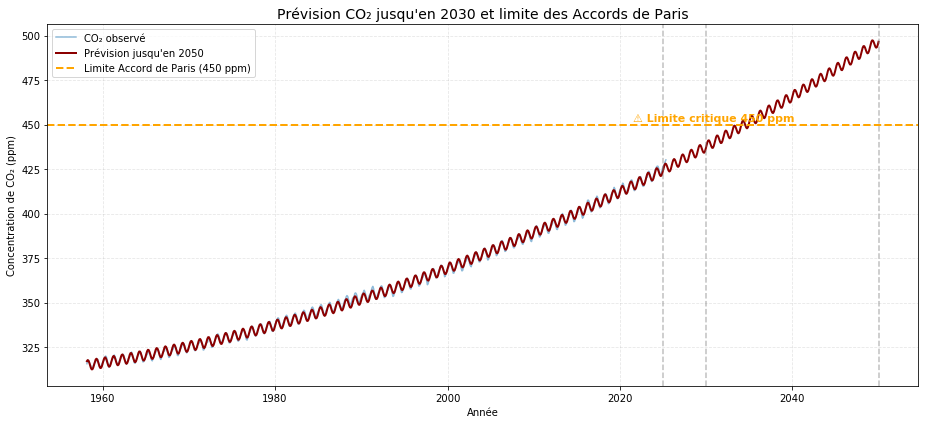

Prévision CO₂ pour 2025 : 424.3 ppm
Prévision CO₂ pour 2030 : 437.4 ppm
Prévision CO₂ pour 2050 : 496.6 ppm


In [112]:
t_future = np.linspace(t_obs.min(), 2050, 1000)
y_predicted = model(t_future, *popt)

plt.figure(figsize=(13, 6))
plt.plot(t_obs, y_obs, label="CO₂ observé", alpha=0.5)
plt.plot(t_future, y_predicted, label="Prévision jusqu'en 2050", color='darkred', linewidth=2)

plt.axhline(450, color='orange', linestyle='--', linewidth=2, label="Limite Accord de Paris (450 ppm)")
plt.text(2021.5, 452, "Limite critique 450 ppm", color='orange', fontsize=11, weight='bold')

plt.axvline(2025, linestyle='--', color='gray', alpha=0.5)
plt.axvline(2030, linestyle='--', color='gray', alpha=0.5)
plt.axvline(2050, linestyle='--', color='gray', alpha=0.5)

plt.title("Prévision CO₂ jusqu'en 2030 et limite des Accords de Paris (COP21)", fontsize=14)
plt.xlabel("Année")
plt.ylabel("Concentration de CO₂ (ppm)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

for year in [2025, 2030, 2050]:
    value = model(year, *popt)
    print(f"Prévision CO₂ pour {year} : {value:.1f} ppm")



### 7. Conclusion

La modélisation conjointe de la tendance de fond et du cycle saisonnier du CO₂ à Mauna Loa montre une croissance continue et inquiétante de la concentration atmosphérique.  
Les prévisions issues de notre ajustement indiquent :

- **424.3 ppm en 2025**,  
- **437.4 ppm en 2030**,  
- **496.6 ppm en 2050**.

Cela signifie que la **limite critique des Accords de Paris (450 ppm)** serait franchie **avant 2040**, si la tendance actuelle se poursuit sans inflexion majeure.  
Ce constat souligne l’urgence d’actions climatiques fortes pour infléchir cette courbe, stabiliser les émissions et éviter des points de bascule irréversibles.
